# SLAF-based Privacy-Preserving CNN1 with Homomorphic Encryption

In [ ]:
!pip install tenseal
!pip install torch torchvision
!pip install matplotlib
!pip install torchsummary

In [ ]:
import torch
import tenseal as ts
from torchvision import datasets
import torchvision
import torchvision.transforms as transforms
import numpy as np
import time
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from torch.nn.utils.fusion import fuse_conv_bn_eval
from time import time

# MNIST dataset

In [ ]:
torch.manual_seed(73)

train_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

classes = train_loader.dataset.classes
onecycle=1

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

if torch.cuda.is_available():
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Not connected to a GPU')
    else:
      print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

**IMPORTANT. Only run one model; testing process will be done on the last model to run!**

## Variables

In [ ]:
def sign(x):
  if x > 0:
    return 1
  elif x < 0:
    return -1
  else:
    return 0

x = np.linspace(-1,1,1000)
z = np.arange(-1, 1, .01)
y = np.sign(z)

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## CNN1

### CNN1-ReLU

CNN1 with original ReLU function

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

onecycle=1
check = []
check2 = []

class Net(torch.nn.Module):
    def __init__(self, hidden=64, output=10):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 4, kernel_size=7, padding=0, stride=3)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.fc1 = torch.nn.Linear(256, hidden)
        self.fc2 = torch.nn.Linear(hidden, output)

    def forward(self, x):
        x = self.conv1(x)
        #Collect activation inputs
        check.append(torch.max(torch.abs(x.data)))
        if torch.max(torch.abs(x.data)) > check[0]:
          check[0] = torch.max(torch.abs(x.data))
        x = F.relu(x)
        x = x.view(-1, 256)
        x = self.fc1(x)
        check2.append(torch.max(torch.abs(x.data)))
        if torch.max(torch.abs(x.data)) > check2[0]:
          check2[0] = torch.max(torch.abs(x.data))
        x = F.relu(x)
        x = self.fc2(x)
        return x

net = Net()
print(net)

summary(net, (1, 28, 28))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


if torch.cuda.is_available():
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Not connected to a GPU')
    else:
      print(gpu_info)
    net.to(device)

### CNN1-X^2

CNN1 model using x^2 as activation function

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

onecycle=1

class Net(torch.nn.Module):
    def __init__(self, hidden=64, output=10):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 4, kernel_size=7, padding=0, stride=3)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.fc1 = torch.nn.Linear(256, hidden)
        self.fc2 = torch.nn.Linear(hidden, output)

    def forward(self, x):
        x = self.conv1(x)
        x = x * x
        x = x.view(-1, 256)
        x = self.fc1(x)
        x = x * x
        x = self.fc2(x)
        return x

net = Net()
print(net)

summary(net, (1, 28, 28))

### CNN1-SLAF

CNN1 model using SLAF

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

        if alpha == None:
            self.alpha = nn.Parameter(torch.tensor(1000,64))
        else:
            for i in range(alpha + 1):
                setattr(self, "alpha" + str(i), torch.nn.Parameter(torch.zeros(1)))
                setattr(self, "alpha" + str(i) + ".requiresGrad", True)

    def forward(self, x, size):
        ar_al = torch.zeros(self.alpha + 1, len(x), size)
        f = open('f1.txt', 'w')
        for i in range(self.alpha + 1):
            temp = getattr(self, "alpha" + str(i))
            ar_al[i] = temp * (x**i)
            f.write(str(temp.data.tolist()) + '\n')
        f.close()
        return torch.sum(ar_al, dim=0)

class conv_soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(conv_soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

        if alpha == None:
            self.alpha = nn.Parameter(torch.tensor(1000,64))
        else:
            for i in range(alpha + 1):
                setattr(self, "alpha" + str(i), torch.nn.Parameter(torch.zeros(1)))
                setattr(self, "alpha" + str(i) + ".requiresGrad", True)

    def forward(self, x):
        ar_al = torch.zeros(self.alpha + 1, len(x), 4, 8, 8)
        f = open('conv.txt', 'w')
        for i in range(self.alpha + 1):
            temp = getattr(self, "alpha" + str(i))
            ar_al[i] = temp * (x**i)
            f.write(str(temp.data.tolist()) + '\n')
        f.close()
        return torch.sum(ar_al, dim=0)

def getPolyVal(x, coeffs):
        curVal = 0
        for curValIndex in range(len(coeffs)):
            curVal=curVal+(coeffs[curValIndex]*x)
        return curVal

class ConvNet(torch.nn.Module):
    def __init__(self, hidden=64, output=10):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 4, kernel_size=7, padding=0, stride=3)
        self.fc1 = torch.nn.Linear(256, hidden)
        self.fc2 = torch.nn.Linear(hidden, output)
        self.slu = soft_poly(hidden, alpha=3)
        self.cslu = conv_soft_poly(hidden, alpha=3)
        self.hidden_size = hidden

    def forward(self, x):
        x = self.conv1(x)
        x = self.cslu(x)
        x = x.view(-1, 256)
        x = self.fc1(x)
        x = self.slu(x, 64)
        x = self.fc2(x)
        return x

net = ConvNet()
print(net)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

if torch.cuda.is_available():
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Not connected to a GPU')
    else:
      print(gpu_info)

    net.to(device)

ConvNet(
  (conv1): Conv2d(1, 4, kernel_size=(7, 7), stride=(3, 3))
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (slu): soft_poly()
  (cslu): conv_soft_poly()
)
cpu


### CNN1-SLAF-R

1. Train CNN with ReLU (above)
2. Re-train with SLAF-R; weights are fixed using requires_grad = False
3. Collapse retrained model
4. Test collapsed model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

        if alpha == None:
            self.alpha = nn.Parameter(torch.tensor(1000,64, device = device))
        else:
            for i in range(alpha + 1):
                tensor_new = torch.nn.Parameter(torch.zeros(1, device = device))
                setattr(self, "alpha" + str(i), tensor_new)
                setattr(self, "alpha" + str(i) + ".requiresGrad", True)

    def forward(self, x, size):
        ar_al = torch.zeros(self.alpha + 1, len(x), size, device = device)
        f = open('f1.txt', 'w')
        for i in range(self.alpha + 1):
            temp = getattr(self, "alpha" + str(i))
            ar_al[i] = temp * (x**i)
            f.write(str(temp.data.tolist()) + '\n')
        f.close()
        return torch.sum(ar_al, dim=0)

class conv_soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(conv_soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

        # initialize alphai
        if alpha == None:
            self.alpha = nn.Parameter(torch.tensor(1000,64, device = device))
        else:
            for i in range(alpha + 1):
                tensor_new = torch.nn.Parameter(torch.zeros(1, device = device))
                setattr(self, "alpha" + str(i), tensor_new)
                setattr(self, "alpha" + str(i) + ".requiresGrad", True)

    def forward(self, x):
        ar_al = torch.zeros(self.alpha + 1, len(x), 4, 8, 8, device=device)
        f = open('conv.txt', 'w')
        for i in range(self.alpha + 1):
            temp = getattr(self, "alpha" + str(i))
            ar_al[i] = temp * (x**i)
            f.write(str(temp.data.tolist()) + '\n')
        f.close()
        return torch.sum(ar_al, dim=0)

class ConvNet(torch.nn.Module):
    def __init__(self, hidden=64, output=10):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 4, kernel_size=7, padding=0, stride=3)
        for param in self.conv1.parameters():
            param.data.requires_grad = False
        self.fc1 = torch.nn.Linear(256, hidden)
        for param in self.fc1.parameters():
            param.data.requires_grad = False
        self.fc2 = torch.nn.Linear(hidden, output)
        for param in self.fc2.parameters():
            param.data.requires_grad = False
        self.slu = soft_poly(hidden, alpha=3)
        self.cslu = conv_soft_poly(hidden, alpha=3)
        self.hidden_size = hidden

    def forward(self, x):
        x = self.conv1(x)
        x = self.cslu(x)
        x = x.view(-1, 256)
        x = self.fc1(x)
        x = self.slu(x, 64)
        x = self.fc2(x)
        return x

net_dos = ConvNet()

if torch.cuda.is_available():
  net_dos.to(device)

print(net_dos)

In [ ]:
print(dict(net.named_parameters()))

In [ ]:
# To recover the saved model for re-training SLAF
PATH = './mnist_net.pth'
net_dos.load_state_dict(torch.load(PATH), strict=False)
net = net_dos

### CNN1-SLAF-P

Polynomial Base

APROXIMANDO POR LEAST SQUARES ....
[ 4.68750043e-04  9.37500046e-02 -1.21527811e-06 -8.10185410e-05]
ESCRIBIENDO EN F1 y CONV ....
            3             2
-8.102e-05 x - 1.215e-06 x + 0.09375 x + 0.0004688


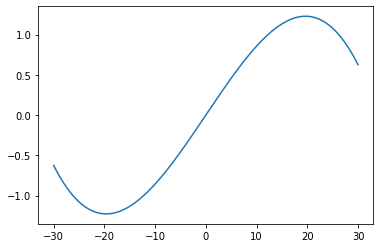

In [ ]:
GRADO = 3

def sign(x_my):
  if x_my > 0:
    return 1
  elif x_my < 0:
    return -1
  else:
    return 0

def comparison(enc_x):
    return enc_x.polyval([0.5, 0.197, 0, -0.004])

z_my = np.arange(-30, 30, 0.01)
y_my = np.sign(z_my)

LEAST_SQUARES = 0
COMPOSITION = 1
CHEBYSHEV = 2
NEWTHON = 3
FOURIER = 4

SELECTION = LEAST_SQUARES

if SELECTION == LEAST_SQUARES:
    print("APPROXIMATING BY LEAST SQUARES ....")
    polynomial = np.polyfit(z_my, y_my, GRADO)
    polynomial = polynomial[::-1]
    print(polynomial)
    print("WRITING IN F1 AND CONV FILES ....")
    f = open('f1.txt', 'w')
    conv = open('conv.txt', 'w')
    for i in range(GRADO + 1):
        f.write('['+str(polynomial[i].tolist()) +']'+ '\n')
        conv.write('['+str(polynomial[i].tolist()) +']'+ '\n')
    f.close()
    conv.close()

elif SELECTION == CHEBYSHEV:
    print("APPROXIMATING BY CHEBYSHEV")
    if GRADO == 3:
        polynomial = [0, (7/3)*(1/30), 0, -(4/3)*(1/27000)]
    else:
        polynomial = [0, 1.2797, 0, -0.4444, 0, 0.2901 ,0, -0.2365, 0, 0.1111]
    print(polynomial)
    print("WRITING IN F1 AND CONV FILES ....")
    f = open('f1.txt', 'w')
    conv = open('conv.txt', 'w')
    for i in range(GRADO + 1):
        f.write('['+str(polynomial[i]) +']'+ '\n')
        conv.write('['+str(polynomial[i]) +']'+ '\n')
    f.close()
    conv.close()

elif SELECTION == COMPOSITION:
    print("APPROXIMATING BY COMPOSITION ....")
    if GRADO == 3:
        polynomial = [0, (2126/1024), 0, (-1359/1024)]
        polynomial = [0, (2126/1024)*(1/30), 0, (-1359/1024)*(1/27000)]
    else:
        f = np.poly1d([(-1/2), 0, (3/2),0])
        g = np.poly1d([(-1359/1024), 0, (2126/1024),0])
        polynomial = f(g)
    print(polynomial)
    print("WRITING IN F1 AND CONV FILES ....")
    f = open('f1.txt', 'w')
    conv = open('conv.txt', 'w')
    for i in range(GRADO + 1):
        f.write('['+str(polynomial[i]) +']'+ '\n')
        conv.write('['+str(polynomial[i]) +']'+ '\n')
    f.close()
    conv.close()

elif SELECTION == NEWTHON:
    print("APPROXIMATING BY NEWTON ....")
    polynomial = [0, (3/2)*(1/30), 0, (-1/2)*(1/27000)]
    print(polynomial)
    print("WRITING IN F1 AND CONV FILES ....")
    f = open('f1.txt', 'w')
    conv = open('conv.txt', 'w')
    for i in range(GRADO + 1):
        f.write('['+str(polynomial[i]) +']'+ '\n')
        conv.write('['+str(polynomial[i]) +']'+ '\n')
    f.close()
    conv.close()

## GRAPH THE POLYNOMIAL
f = open('conv.txt', 'r')
list_take=[]

for i in range(GRADO + 1):
    take = float(f.readline().replace('[','').replace(']',''))
    list_take.append(take)
f.close()

list_take.reverse()
poly_ = np.poly1d(list_take)
print(poly_)

fig = plt.figure()
ax = fig.add_subplot(111)
poly_ff = [np.polyval(poly_, i) for i in z_my]

ax.plot(z_my, poly_ff)

CNN1 model using SLAF-P

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

        if alpha == None:
            self.alpha = nn.Parameter(torch.tensor(1000,64))
        else:
            f = open('f1.txt', 'r')
            for i in range(alpha + 1):
                next_value = float(f.readline().replace('[','').replace(']',''))
                setattr(self, "alpha" + str(i), torch.tensor(next_value))
                setattr(self, "alpha" + str(i) + ".requiresGrad", True)
            f.close()

    def forward(self, x, size):
        ar_al = torch.zeros(self.alpha + 1, len(x), size)
        f = open('f1.txt', 'w')
        for i in range(self.alpha + 1):
            temp = getattr(self, "alpha" + str(i))
            ar_al[i] = temp * (x**i)
            f.write(str(temp.data.tolist()) + '\n')
        f.close()
        return torch.sum(ar_al, dim=0)

class conv_soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(conv_soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

        if alpha == None:
            self.alpha = nn.Parameter(torch.tensor(1000,64))
        else:
            f = open('conv.txt', 'r')
            for i in range(alpha + 1):
                next_value = float(f.readline().replace('[','').replace(']',''))
                setattr(self, "alpha" + str(i), torch.tensor(next_value))
                setattr(self, "alpha" + str(i) + ".requiresGrad", True)
            f.close()

    def forward(self, x):
        ar_al = torch.zeros(self.alpha + 1, len(x), 4, 8, 8)
        f = open('conv.txt', 'w')
        for i in range(self.alpha + 1):
            temp = getattr(self, "alpha" + str(i))
            ar_al[i] = temp * (x**i)
            f.write(str(temp.data.tolist()) + '\n')
        f.close()
        return torch.sum(ar_al, dim=0)

class ConvNet(torch.nn.Module):
    def __init__(self, hidden=64, output=10):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 4, kernel_size=7, padding=0, stride=3)
        nn.init.kaiming_normal_(self.conv1.weight)
        for param in self.conv1.parameters():
            param.data.requires_grad = False
        self.fc1 = torch.nn.Linear(256, hidden)
        for param in self.fc1.parameters():
            param.data.requires_grad = False
        self.fc2 = torch.nn.Linear(hidden, output)
        for param in self.fc2.parameters():
            param.data.requires_grad = False
        self.slu = soft_poly(hidden, alpha=3)
        self.cslu = conv_soft_poly(hidden, alpha=3)
        self.hidden_size = hidden

    def forward(self, x):
        x = self.conv1(x)
        #ReLU using equivalence with sign
        x = (x + x*self.cslu(x))/2
        x = x.view(-1, 256)
        x = self.fc1(x)
        x = (x + x*self.slu(x, 64))/2
        x = self.fc2(x)
        return x

net_dos = ConvNet()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
print(net_dos.state_dict())

In [ ]:
# To recover the saved model for retraining SLAF-P, i.e., CNN1-SLAF-P-R
PATH = './mnist_net.pth'
net_dos.load_state_dict(torch.load(PATH), strict=False)
net = net_dos

## One-Cycle

In [ ]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()

        avg_loss = loss/(1 - beta**i)

        acc_ = ((torch.argmax(scores, dim=1) == y).sum()/scores.size(0))
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

        accuracies.append(acc_.item())

        losses.append(avg_loss)
        log_lrs.append(lr)

        cost.backward()
        optimiser.step()

        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr

    return log_lrs, losses, accuracies

## Training

In [ ]:
#ADAM
import torch.optim as optim
onecycle = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
#SGD with One-cycle
import torch.optim as optim
onecycle =1
criterion = nn.CrossEntropyLoss()
if onecycle==1:
  optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.95, weight_decay=1e-4)
  print("With One-Cycle")
else:
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
  print("Without One-Cycle")

With One-Cycle


In [ ]:
lg_lr, losses, accuracies = find_lr(net, optimizer, start_val=1e-6, end_val=10)

In [ ]:
f1, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
ax1.set_xticks([1e-1, 2e-1, 1, 10])
ax1.get_xaxis().get_major_formatter().labelOnlyBase = False
plt.show()

In [ ]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer,
                                                max_lr=2e-1,
                                                steps_per_epoch=len(train_loader),
                                                epochs = 30, pct_start=0.43,
                                                div_factor=10,
                                                final_div_factor=1000,
                                                three_phase=True, verbose=False
                                            )

In [ ]:
print(len(train_loader))

938


In [ ]:
def train(model, train_loader, criterion, optimizer, n_epochs=30):
    model.train()

    if onecycle == 1:
      print("With One-Cycle")
    else:
      print("Without One-Cycle")

    for epoch in range(1, n_epochs+1):

        train_loss = 0.0
        correct_new = 0
        total_new = 0
        for data, target in train_loader:
            if torch.cuda.is_available():
              data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_new += target.size(0)
            correct_new += (predicted == target).sum().item()

            #One-cycle
            if onecycle == 1:
              scheduler.step()

        # calculate average losses
        train_loss = train_loss / len(train_loader)
        acc_new = 100 * correct_new / total_new

        print('Epoch: {} \tTraining Loss: {:.6f} \tCorrect: {} \tAccuracy: {:.3f}'.format(epoch, train_loss, correct_new, acc_new))

    print('Finished Training')

    return model

In [ ]:
net = train(net, train_loader, criterion, optimizer)

In [ ]:
#Save the model for re-training
PATH = './mnist_net_.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
print(check[0])
print(check2[0])

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

## Plaintext testing

In [ ]:
def test(model, test_loader, criterion):
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval()
    j = 0
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()
        _, pred = torch.max(output, 1)
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss/len(test_loader)
    print(f'Test Loss: {test_loss:.6f}\n')

    for label in range(10):
        print(
            f'Test Accuracy of {label}: {int(100 * class_correct[label] / class_total[label])}% '
            f'({int(np.sum(class_correct[label]))}/{int(np.sum(class_total[label]))})'
        )

    print(
        f'\nTest Accuracy (Overall): {int(100 * np.sum(class_correct) / np.sum(class_total))}% '
        f'({int(np.sum(class_correct))}/{int(np.sum(class_total))})'
    )

In [ ]:
t_start = time()
test(net, test_loader, criterion)
t_end = time()
t_total = (t_end - t_start)*1000
print(t_total)

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'{classname:5s} is {accuracy:.2f} %')

# Ciphertext testing

COPY F1 and CONV1 to ciphertext files.

# CNN1-HE

## CNN1-HE-X^2

In [ ]:
"""
It's a PyTorch-like model using operations implemented in TenSEAL.
    - .mm() method is doing the vector-matrix multiplication explained above.
    - you can use + operator to add a plain vector as a bias.
    - .conv2d_im2col() method is doing a single convlution operation.
    - .square_() just square the encrypted vector inplace.
"""

class EncConvNet:
    def __init__(self, torch_nn):
        self.conv1_weight = torch_nn.conv1.weight.data.view(
            torch_nn.conv1.out_channels, torch_nn.conv1.kernel_size[0],
            torch_nn.conv1.kernel_size[1]
        ).tolist()
        self.conv1_bias = torch_nn.conv1.bias.data.tolist()

        self.fc1_weight = torch_nn.fc1.weight.T.data.tolist()
        self.fc1_bias = torch_nn.fc1.bias.data.tolist()

        self.fc2_weight = torch_nn.fc2.weight.T.data.tolist()
        self.fc2_bias = torch_nn.fc2.bias.data.tolist()

    def forward(self, enc_x, windows_nb):
        # conv layer
        enc_channels = []
        for kernel, bias in zip(self.conv1_weight, self.conv1_bias):
            y = enc_x.conv2d_im2col(kernel, windows_nb) + bias
            enc_channels.append(y)
        # pack all channels into a single flattened vector
        enc_x = ts.CKKSVector.pack_vectors(enc_channels)
        # square activation
        enc_x.square_()
        # fc1 layer
        enc_x = enc_x.mm(self.fc1_weight) + self.fc1_bias
        # square activation
        enc_x.square_()
        # fc2 layer
        enc_x = enc_x.mm(self.fc2_weight) + self.fc2_bias
        return enc_x

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

def enc_test(context, model, test_loader, criterion, kernel_shape, stride):
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    for data, target in test_loader:
        # Encoding and encryption
        x_enc, windows_nb = ts.im2col_encoding(
            context, data.view(28, 28).tolist(), kernel_shape[0],
            kernel_shape[1], stride
        )
        # Encrypted evaluation
        enc_output = enc_model(x_enc, windows_nb)
        # Decryption of result
        output = enc_output.decrypt()
        output = torch.tensor(output).view(1, -1)

        # compute loss
        loss = criterion(output, target)
        test_loss += loss.item()

        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        label = target.data[0]
        class_correct[label] += correct.item()
        class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss / sum(class_total)
    print(f'Test Loss: {test_loss:.6f}\n')

    for label in range(10):
        print(
            f'Test Accuracy of {label}: {int(100 * class_correct[label] / class_total[label])}% '
            f'({int(np.sum(class_correct[label]))}/{int(np.sum(class_total[label]))})'
        )

    print(
        f'\nTest Accuracy (Overall): {int(100 * np.sum(class_correct) / np.sum(class_total))}% '
        f'({int(np.sum(class_correct))}/{int(np.sum(class_total))})'
    )

# Load one element at a time
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
# required for encoding
kernel_shape = net.conv1.kernel_size
stride = net.conv1.stride[0]

In [ ]:
# Encryption Parameters

# Controls precision of the fractional part
bits_scale = 26
# Create TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[31, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, 31]
)
# Set the scale
context.global_scale = pow(2, bits_scale)
# Galois keys are required to do ciphertext rotations
context.generate_galois_keys()

In [ ]:
enc_model = EncConvNet(net)
enc_test(context, enc_model, test_loader, criterion, kernel_shape, stride)

## CNN1-HE-SLAF

In [ ]:
class enc_conv_soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(enc_conv_soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

    def forward(self, x, context):
        ar_al = ts.ckks_vector(context, torch.zeros(1, device = device))
        f = open('t_conv.txt', 'r')
        l = [line.strip() for line in f]
        t = [float(item) for item in l]
        for i in range(self.alpha + 1):
            ar_al = ar_al + (x**i)*t[i]
        return ar_al

class enc_soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(enc_soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

    def forward(self, x, context):
        ar_al = ts.ckks_vector(context,torch.zeros(1, device=device))
        f = open('t_f1.txt', 'r')
        l = [line.strip() for line in f]
        t = [float(item) for item in l]
        for i in range(self.alpha + 1):
            temp = (x**i) * t[i]
            ar_al = ar_al + temp
        return ar_al

class EncConvNet:
    def __init__(self, torch_nn):
        self.conv1_weight = torch_nn.conv1.weight.data.view(
            torch_nn.conv1.out_channels, torch_nn.conv1.kernel_size[0],
            torch_nn.conv1.kernel_size[1]
        ).tolist()
        self.conv1_bias = torch_nn.conv1.bias.data.tolist()

        self.fc1_weight = torch_nn.fc1.weight.T.data.tolist()
        self.fc1_bias = torch_nn.fc1.bias.data.tolist()
        self.fc2_weight = torch_nn.fc2.weight.T.data.tolist()
        self.fc2_bias = torch_nn.fc2.bias.data.tolist()
        self.slu = enc_soft_poly(64, alpha=3)
        self.cslu = enc_conv_soft_poly(10, alpha=3)

    def forward(self, enc_x, windows_nb, context):
        # conv layer
        enc_channels = []
        for kernel, bias in zip(self.conv1_weight, self.conv1_bias):
            y = enc_x.conv2d_im2col(kernel, windows_nb) + bias
            enc_channels.append(y)
        # pack all channels into a single flattened vector
        enc_x = ts.CKKSVector.pack_vectors(enc_channels)
        enc_x = self.cslu(enc_x, context)
        # fc1 layer
        enc_x = enc_x.mm(self.fc1_weight) + self.fc1_bias
        enc_x = self.slu(enc_x,  context)
        # fc2 layer
        enc_x = enc_x.mm(self.fc2_weight) + self.fc2_bias
        return enc_x

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

def enc_test(context, model, test_loader, criterion, kernel_shape, stride, prog):
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    j = 0
    n_n = [0] * 10000
    n_n_d = [0] * 10000
    for data, target in test_loader:
        j = j + 1
        start_time = time.time()
        # Encoding and encryption
        x_enc, windows_nb = ts.im2col_encoding(
            context, data.view(28, 28).tolist(), kernel_shape[0],
            kernel_shape[1], stride
        )
        # Encrypted evaluation
        start_time = time.time()
        enc_output = enc_model(x_enc, windows_nb, context)
        n_n[j-1] = (time.time() - start_time)
        print("only one test time: ","--- %s seconds ---" % (time.time() - start_time))
        # Decryption of result
        output = enc_output.decrypt()
        output = torch.tensor(output).view(1, -1)
        n_n_d[j-1] = (time.time() - start_time)
        # compute loss
        loss = criterion(output, target)
        test_loss += loss.item()
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        label = target.data[0]
        class_correct[label] += correct.item()
        class_total[label] += 1

    #Original indicates as j-1
    for i in range (0, j-2):
        prog.write(str("test without decrypt №") + str(i) + str(" time: : ") + str(n_n[i]) + str('\n'))
    for i in range (0, j-2):
        prog.write(str("test with decrypt №") + str(i) + str(" time: : ") + str(n_n_d[i]) + str('\n'))

    # calculate and print avg test loss
    test_loss = test_loss / sum(class_total)
    print(f'Test Loss: {test_loss:.6f}\n')

    for label in range(10):
        print(
            f'Test Accuracy of {label}: {int(100 * class_correct[label] / class_total[label])}% '
            f'({int(np.sum(class_correct[label]))}/{int(np.sum(class_total[label]))})'
        )
        prog.write(str( f'Test Accuracy of {label}: {int(100 * class_correct[label] / class_total[label])}% ') + str(f'({int(np.sum(class_correct[label]))}/{int(np.sum(class_total[label]))})'))

    print(
        f'\nTest Accuracy (Overall): {int(100 * np.sum(class_correct) / np.sum(class_total))}% '
        f'({int(np.sum(class_correct))}/{int(np.sum(class_total))})'
    )
    prog.write(str( f'\nTest Accuracy (Overall): {int(100 * np.sum(class_correct) / np.sum(class_total))}% ') + str(f'({int(np.sum(class_correct))}/{int(np.sum(class_total))})'))

# Load one element at a time
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
# required for encoding
kernel_shape = net.conv1.kernel_size
stride = net.conv1.stride[0]

In [ ]:
bits_scale = 26

# Create TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=16384,
    coeff_mod_bit_sizes=[40, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, 40]
)

# set the scale
context.global_scale = pow(2, bits_scale)
# galois keys are required to do ciphertext rotations
context.generate_galois_keys()

In [ ]:
enc_model = EncConvNet(net)

prog = open('tests.txt', 'w', encoding='utf-8')
start_time = time.time()
enc_test(context, enc_model, test_loader, criterion, kernel_shape, stride, prog)
print("full time process: ","--- %s seconds ---" % (time.time() - start_time))
prog.write(str("full time process: ") + str((time.time() - start_time)))
prog.close()

## CNN1-HE-SLAF (with ReLU = x + x * sign(x)*/2)

In [ ]:
class enc_conv_soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(enc_conv_soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

    def forward(self, x, context):
        ar_al = ts.ckks_vector(context, torch.zeros(1, device = device))
        f = open('t_conv.txt', 'r')
        l = [line.strip() for line in f]
        t = [float(item) for item in l]
        for i in range(self.alpha + 1):
            ar_al = ar_al + (x**i)*t[i]
        return ar_al

class enc_soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(enc_soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

    def forward(self, x, context):
        ar_al = ts.ckks_vector(context,torch.zeros(1, device=device))
        f = open('t_f1.txt', 'r')
        l = [line.strip() for line in f]
        t = [float(item) for item in l]
        for i in range(self.alpha + 1):
            temp = (x**i) * t[i]
            ar_al = ar_al + temp
        return ar_al

class EncConvNet:
    def __init__(self, torch_nn):
        self.conv1_weight = torch_nn.conv1.weight.data.view(
            torch_nn.conv1.out_channels, torch_nn.conv1.kernel_size[0],
            torch_nn.conv1.kernel_size[1]
        ).tolist()
        self.conv1_bias = torch_nn.conv1.bias.data.tolist()

        self.fc1_weight = torch_nn.fc1.weight.T.data.tolist()
        self.fc1_bias = torch_nn.fc1.bias.data.tolist()
        self.fc2_weight = torch_nn.fc2.weight.T.data.tolist()
        self.fc2_bias = torch_nn.fc2.bias.data.tolist()
        self.slu = enc_soft_poly(64, alpha=3)
        self.cslu = enc_conv_soft_poly(10, alpha=3)
        self.dos_plaintext = [0.5] * 256
        self.dos_plaintext_ = [0.5] * 64

    def forward(self, enc_x, windows_nb, context):
        # conv layer
        enc_channels = []
        for kernel, bias in zip(self.conv1_weight, self.conv1_bias):
            y = enc_x.conv2d_im2col(kernel, windows_nb) + bias
            enc_channels.append(y)
        # pack all channels into a single flattened vector
        enc_x = ts.CKKSVector.pack_vectors(enc_channels)
        #enc_x = self.cslu(enc_x, context)
        enc_x = (enc_x + enc_x * self.cslu(enc_x, context)) * self.dos_plaintext
        # fc1 layer
        enc_x = enc_x.mm(self.fc1_weight) + self.fc1_bias
        #enc_x = self.slu(enc_x,  context)
        enc_x = (enc_x + enc_x * self.slu(enc_x,  context)) * self.dos_plaintext_
        # fc2 layer
        enc_x = enc_x.mm(self.fc2_weight) + self.fc2_bias
        return enc_x

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

def enc_test(context, model, test_loader, criterion, kernel_shape, stride, prog):
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    j = 0
    n_n = [0] * 10000
    n_n_d = [0] * 10000
    for data, target in test_loader:
        j = j + 1
        start_time = time.time()
        # Encoding and encryption
        x_enc, windows_nb = ts.im2col_encoding(
            context, data.view(28, 28).tolist(), kernel_shape[0],
            kernel_shape[1], stride
        )
        # Encrypted evaluation
        start_time = time.time()
        enc_output = enc_model(x_enc, windows_nb, context)
        n_n[j-1] = (time.time() - start_time)
        print("only one test time: ","--- %s seconds ---" % (time.time() - start_time))
        # Decryption of result
        output = enc_output.decrypt()
        output = torch.tensor(output).view(1, -1)
        n_n_d[j-1] = (time.time() - start_time)
        # compute loss
        loss = criterion(output, target)
        test_loss += loss.item()
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        label = target.data[0]
        class_correct[label] += correct.item()
        class_total[label] += 1

    for i in range (0, j-2):
        prog.write(str("test without decrypt №") + str(i) + str(" time: : ") + str(n_n[i]) + str('\n'))
    for i in range (0, j-2):
        prog.write(str("test with decrypt №") + str(i) + str(" time: : ") + str(n_n_d[i]) + str('\n'))

    # calculate and print avg test loss
    test_loss = test_loss / sum(class_total)
    print(f'Test Loss: {test_loss:.6f}\n')

    for label in range(10):
        print(
            f'Test Accuracy of {label}: {int(100 * class_correct[label] / class_total[label])}% '
            f'({int(np.sum(class_correct[label]))}/{int(np.sum(class_total[label]))})'
        )
        prog.write(str( f'Test Accuracy of {label}: {int(100 * class_correct[label] / class_total[label])}% ') + str(f'({int(np.sum(class_correct[label]))}/{int(np.sum(class_total[label]))})'))

    print(
        f'\nTest Accuracy (Overall): {int(100 * np.sum(class_correct) / np.sum(class_total))}% '
        f'({int(np.sum(class_correct))}/{int(np.sum(class_total))})'
    )
    prog.write(str( f'\nTest Accuracy (Overall): {int(100 * np.sum(class_correct) / np.sum(class_total))}% ') + str(f'({int(np.sum(class_correct))}/{int(np.sum(class_total))})'))

# Load one element at a time
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
# required for encoding
kernel_shape = net.conv1.kernel_size
stride = net.conv1.stride[0]

In [ ]:
bits_scale = 26

# Create TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=16384,
    coeff_mod_bit_sizes=[35,bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, 35]
)

# set the scale
context.global_scale = pow(2, bits_scale)
# galois keys are required to do ciphertext rotations
context.generate_galois_keys()

In [ ]:
## New Encryption Parameters
bits_scale = 25

# Create TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=16384,
        coeff_mod_bit_sizes=[40,bits_scale,bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, 40]
)

# set the scale
context.global_scale = pow(2, bits_scale)
# galois keys are required to do ciphertext rotations
context.generate_galois_keys()

In [ ]:
enc_model = EncConvNet(net)

prog = open('tests.txt', 'w', encoding='utf-8')
start_time = time.time()
enc_test(context, enc_model, test_loader, criterion, kernel_shape, stride, prog)
print("full time process: ","--- %s seconds ---" % (time.time() - start_time))
prog.write(str("full time process: ") + str((time.time() - start_time)))
prog.close()